In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.font_manager import FontProperties
import warnings
warnings.filterwarnings("ignore")

In [3]:
data1 = pd.read_excel("./231118 Production + disposal capacity.xlsx")
city_name =np.array(["rate"]+data1.iloc[:,0].tolist())
ED = data1.iloc[:,3]+data1.iloc[:,4]
MD = data1.iloc[:,6]

In [4]:
data2 = pd.read_excel("./Urban sorting and disposal capacity.xlsx")
CD = []
for i in range(4):
    CD.append({
        "CD":data2.iloc[2:,i+2],
        "type":f"O{i+1}"
    })

In [6]:
def getMet(CD,MD,type,max_iter):
    CD += 0.1*np.ones(CD.shape)
    n = data1.shape[0]
    column_name = ["Constant load rate of <50%","Constant load rate of 50%","Constant load rate of 100%","Constant load rate of 150%"]
    r1_dict = {
        # Based on normal distribution : mu=50%,sigma=20%
        "Ongoing closure -- Mild growth":np.array(np.random.normal(0.5,0.2,[n,max_iter]),dtype=np.float16),
        # Based on normal distribution : mu=100%,sigma=40%
        "Ongoing embargo -- Moderate growth":np.array(np.random.normal(1,0.4,[n,max_iter]),dtype=np.float16),
        # Based on normal distribution : mu=150%,sigma=60%
        "Continuation of the embargo -- Serious growth":np.array(np.random.normal(1.5,0.6,[n,max_iter]),dtype=np.float16),
        # Based on lognormal distribution : mu=ln(200%),sigma=0.3
        "Immediate liberalisation -- Rapid growth":np.array(np.random.lognormal(np.log(2),0.3,[n,max_iter]),dtype=np.float16),
        # Based on uniform distribution : a=0,b=0.5
        "Immediate liberalisation -- Slow growth":np.array(np.random.uniform(0,0.5,[n,max_iter]),dtype=np.float16),
        # Based on normal distribution : mu=0.75,b=0.5
        "Flexibility to adjust -- Gradual growth":np.array(np.random.normal(0.75,0.5,[n,max_iter]),dtype=np.float16),
        # Based on uniform distribution : a=-0.1,b=0.1
        "Flexible Adjustment -- Stabilisation":np.array(np.random.uniform(-0.3,0.3,[n,max_iter]),dtype=np.float16),
    }
    r1_list = r1_dict.values()
    r1_name_list = list(r1_dict.keys())
    idx = 0
    for r1 in r1_list :
        LF = (np.array(MD).reshape(-1,1) * (1 + r1)) / np.array(CD).reshape(-1,1)
        ll_list = [column_name]
        for LFi in range(LF.shape[0]) :
            lf = LF[LFi,:]
            l = len(lf)
            l0 = len(lf[lf<0.5])
            l1 = len(lf[lf>=0.5])
            l2 = len(lf[lf>=1])
            l3 = len(lf[lf>=1.5])
            ll = [l0/l,l1/l,l2/l,l3/l]
            ll_list.append(ll)
        ll_list_pd = pd.DataFrame(ll_list,columns=["",r1_name_list[idx],"",""])
        if idx == 0:
            ll_list_pd_all = ll_list_pd
        else:
            ll_list_pd_all = pd.concat([ll_list_pd_all,ll_list_pd],axis=1)
        idx += 1

    ll_list_pd_all = ll_list_pd_all.set_index(keys=city_name)
    ll_list_pd_all.to_excel(f"./new/iter_{max_iter}_{type}.xlsx")

## <font face="Times New Roman">Main Chart Code</font>

In [ ]:
max_iter = 100000
for i in range(4):
    getMet(CD[i]["CD"],MD,CD[i]["type"],max_iter)

In [8]:
# Setting the global line width
mpl.rcParams['hatch.linewidth'] = 4

# Defining font properties
font = FontProperties()
font.set_family('Arial') 
font.set_size(25)

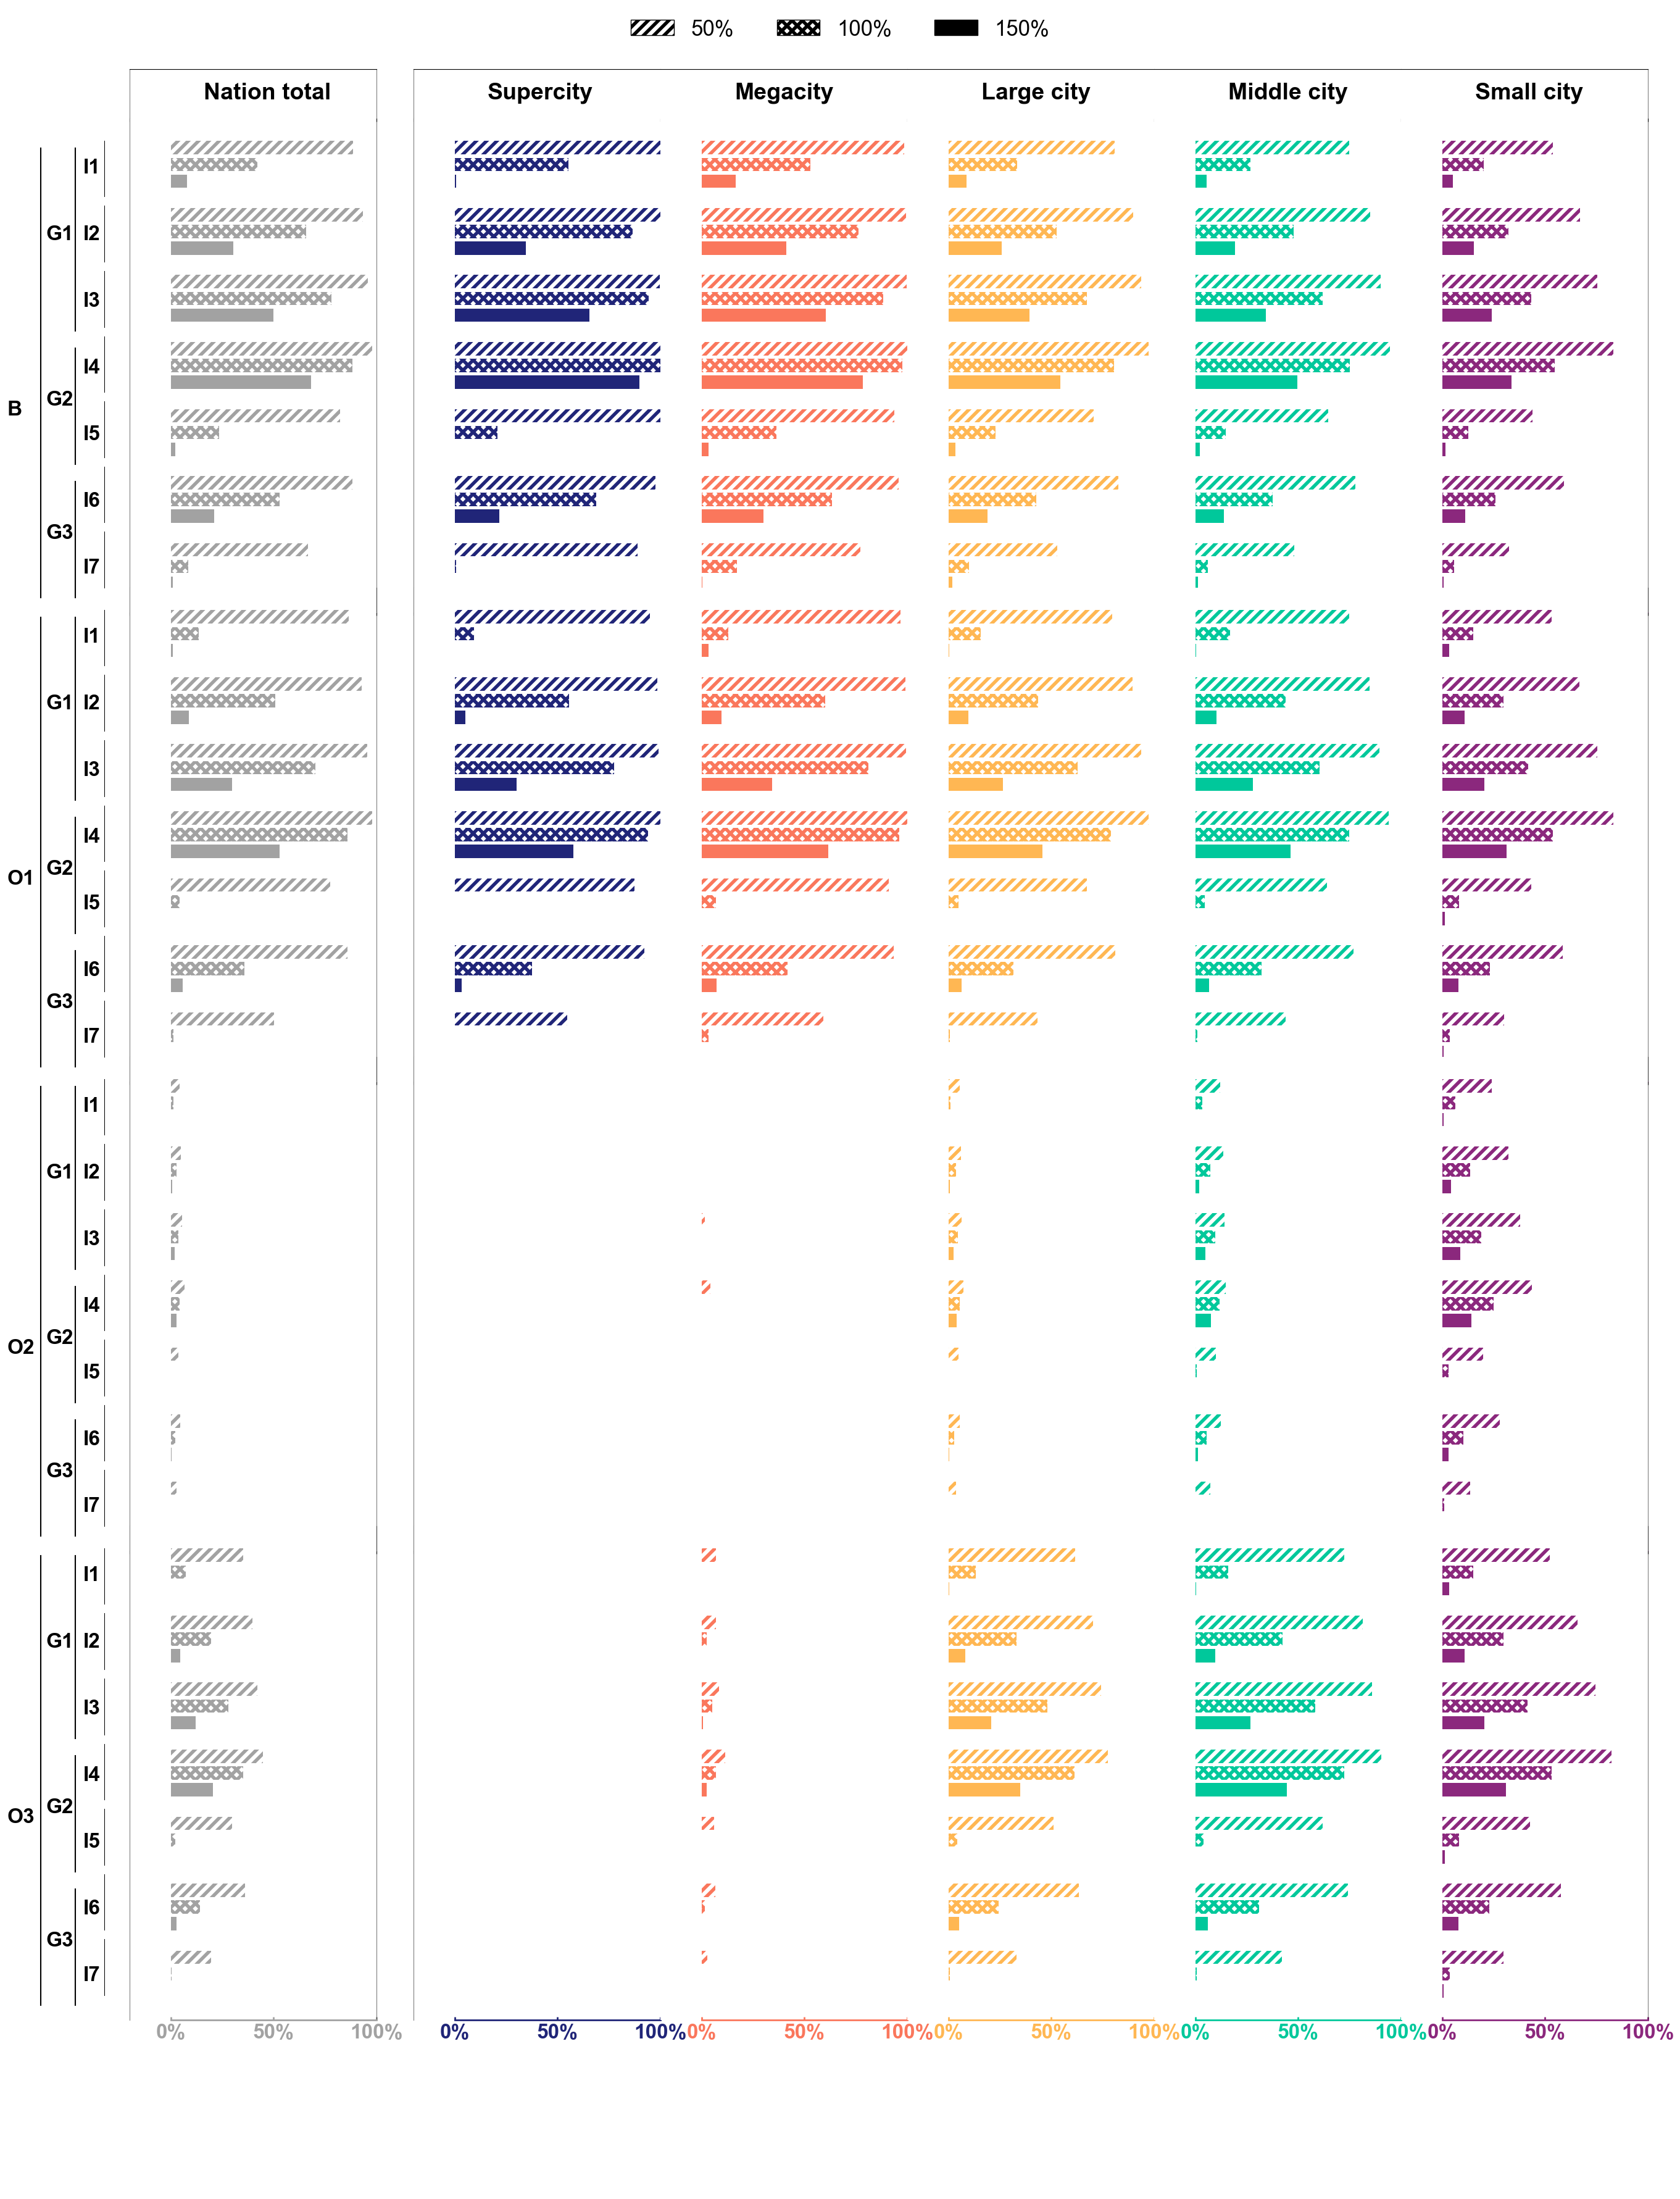

In [19]:
all_list = []
fl = pd.read_excel("./Urban sorting and disposal capacity.xlsx")
max_iter = 500000
for i in range(4) :
    cdtype = CD[i]["type"]
    plt_data = pd.read_excel(f"./iter_{max_iter}_{cdtype}.xlsx")
    fll = np.array(fl.iloc[1:,1])
    plt_data["fl"] = fll
    city_list = ["Super city","Mega city","Large city","Middle city","Small city","Nation total"]
    city_data_list = []
    for city_type in city_list :
        if city_type != "Nation total":
            city = plt_data[plt_data["fl"]==city_type]
            city_data = np.array(np.mean(city.iloc[0:,1:-1],0)).reshape(-1,1)
            ct = []
            for k in range(7) :
                ct.append(city_data[(k*4+1):(k+1)*4])
            city_data = np.array(ct).reshape(-1,1)
            ls = []
            yticks = []
            pz = 1
            for s in range(7):
                ls += [1+(3+pz)*s, 2+(3+pz)*s, 3+(3+pz)*s]
                ytick = np.mean([2+(3+pz)*s, 3+(3+pz)*s])
                yticks.append(ytick)
            ls = np.array(ls[::-1]).reshape(-1,1)
            city_data = np.concatenate([ls,city_data],axis=1)
            city_data_list.append(city_data)
        else :
            ls = []
            yticks = []
            pz = 1
            for s in range(7):
                ls += [1+(3+pz)*s, 2+(3+pz)*s, 3+(3+pz)*s]
                ytick = np.mean([2+(3+pz)*s, 3+(3+pz)*s])
                yticks.append(ytick)
            ls = np.array(ls[::-1]).reshape(-1,1)

            for i in range(4):
                if i == 0:
                    city_datai = city_data_list[i][:,1].copy()
                else :
                    city_datai += city_data_list[i][:,1].copy()
            city_datai = city_datai.reshape(-1,1)
            city_data = np.concatenate([ls,city_datai/4],axis=1)
            city_data_list = [city_data] + city_data_list
        
    all_list.append(city_data_list)

city_list = ["Nation total","Supercity","Megacity","Large city","Middle city","Small city"]
hatch = []
colors = []
line = []
hatch_cell = ["//","xx","**"]

line_cell = [0,0,0]
color_cell = ["white","white","white"]
edgecolor = ["#A2A2A2","#202578","#fa775c","#ffb753","#00c89b","#8b287d"]
for i in range(7) :
    hatch += hatch_cell
    line += line_cell
    colors += color_cell

# plot running
fig,ax = plt.subplots()
fig.set_size_inches(20,40)
ax.set_axis_off()

for j in range(4) :
    if  j == 0:
        cdtype = "B"
    else :
        cdtype = f"O{j}"
    axx = fig.add_subplot(1,6,1)
    axx.set_position([0,0.75-0.19*j,0.08,0.2])
    axx.set_axis_off()
    axx.set_xlim(axx.get_xlim())
    axx.set_ylim(axx.get_ylim())
    # axx.set_axis_on()
    axx.text(0.01,0.4,f"{cdtype}",fontdict={"fontname":"Arial","fontweight":"bold","fontsize":24})
    for i in range(7) :
        axx.text(0.78,0.08+i*0.135,f"I{7-i}",fontdict={"fontname":"Arial","fontweight":"bold","fontsize":24})
    
    mar0 = -0.05
    alx = np.linspace(0.08+0*0.135+mar0,0.08+6*0.135-mar0,100)
    axx.plot(0.35*np.ones(alx.shape),alx,color="black")

    axx.text(0.4,0.15+0*0.34,f"G{3}",fontdict={"fontname":"Arial","fontweight":"bold","fontsize":24})
    axx.text(0.4,0.08+1*0.34,f"G{2}",fontdict={"fontname":"Arial","fontweight":"bold","fontsize":24})
    axx.text(0.4,0.08+3*0.225,f"G{1}",fontdict={"fontname":"Arial","fontweight":"bold","fontsize":24})
    mar = -0.05
    x1 = np.linspace(0.08+4*0.135+mar,0.08+6*0.135-mar,100)
    x2 = np.linspace(0.08+2*0.135+mar,0.08+3*0.135-mar,100)
    x3 = np.linspace(0.08+0*0.135+mar,0.08+1*0.135-mar,100)
    axx.plot(0.7*np.ones(x1.shape),x1,color="black")
    axx.plot(0.7*np.ones(x2.shape),x2,color="black")
    axx.plot(0.7*np.ones(x3.shape),x3,color="black")

    mar2 = 0.01
    xd1 = np.linspace(0.04+6*0.132+mar2,0.04+7*0.132-mar2,100)
    xd2 = np.linspace(0.04+5*0.132+mar2,0.04+6*0.132-mar2,100)
    xd3 = np.linspace(0.04+4*0.132+mar2,0.04+5*0.132-mar2,100)
    xd4 = np.linspace(0.04+3*0.132+mar2,0.04+4*0.132-mar2,100)
    xd5 = np.linspace(0.04+2*0.132+mar2,0.04+3*0.132-mar2,100)
    xd6 = np.linspace(0.04+1*0.132+mar2,0.04+2*0.132-mar2,100)
    xd7 = np.linspace(0.04+0*0.132+mar2,0.04+1*0.132-mar2,100)

    axx_len = 1
    axx.plot(axx_len*np.ones(xd1.shape),xd1,color="black")
    axx.plot(axx_len*np.ones(xd2.shape),xd2,color="black")
    axx.plot(axx_len*np.ones(xd3.shape),xd3,color="black")
    axx.plot(axx_len*np.ones(xd4.shape),xd4,color="black")
    axx.plot(axx_len*np.ones(xd5.shape),xd5,color="black")
    axx.plot(axx_len*np.ones(xd6.shape),xd6,color="black")
    axx.plot(axx_len*np.ones(xd7.shape),xd7,color="black")

    for i in range(6) :
        if j == 0 :
            ax1 = fig.add_subplot(3,6,i+2)
            if i <= 1 :
                ax1.set_position([i*0.23+0.1,0.95,0.2,0.02])
            else :
                ax1.set_position([(i-1)*0.2+0.33,0.95,0.2,0.02])
            ax1.set_axis_on()
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
            ax1.tick_params(axis='y', length=0)
            ax1.spines['bottom'].set_visible(False)
            ax1.spines["left"].set_alpha(0.5)
            ax1.spines["right"].set_alpha(0.5)

            
            ax1.text(0.3,0.4,city_list[i],fontdict={"fontname":"Arial","fontweight":"bold","fontsize":27})
        
        ax2 = fig.add_subplot(3,6,i+7)
        if j != 3:
            ax2.set_axis_on()
            ax2.set_xticklabels([])
            ax2.set_yticklabels([])
            ax2.spines["left"].set_alpha(0.5)
            ax2.spines["right"].set_alpha(0.5)
            ax2.spines['top'].set_visible(False)

            ax2.tick_params(axis='y', length=0)
            ax2.spines['bottom'].set_color(edgecolor[i])
            if j != 0:
                ax2.spines['top'].set_visible(False)
        else :
            ax2.yaxis.set_visible(False)
            for label in ax2.get_yticklabels():
                label.set_visible(False)
            ax2.spines["left"].set_alpha(0.5)

            ax2.spines["right"].set_alpha(0.5)
            ax2.spines['top'].set_visible(False)
            ax2.spines['bottom'].set_color(edgecolor[i])
            ax2.spines['bottom'].set_linewidth(2)
            ax2.tick_params(axis='x', colors=edgecolor[i],width=2)
            
            ax2.set_xticks([0,0.5,1])
            ax2.set_xticklabels(["0%","50%","100%"])
            ax2.tick_params(axis='x',direction='in')
            for label in ax2.get_xticklabels():
                label.set_color(edgecolor[i])
                label.set_fontsize(24)
                label.set_fontweight("bold")
                label.set_fontname("Arial")
        if i == 5 :
            ax2.spines['right'].set_visible(True)
            ax1.spines['right'].set_visible(True)
        else :
            ax2.spines['right'].set_visible(False)
            ax1.spines['right'].set_visible(False)

        if i == 1 :
            ax2.spines['left'].set_visible(True)
            ax1.spines['left'].set_visible(True)
        else :
            ax2.spines['left'].set_visible(False)
            ax1.spines['left'].set_visible(False)

        if i == 0:
            ax2.spines['left'].set_visible(True)
            ax1.spines['left'].set_visible(True)
            
            ax2.spines['right'].set_visible(True)
            ax1.spines['right'].set_visible(True)
        
        ax2.set_xlim(-0.2,1)
        ax2.spines['bottom'].set_bounds(0,1)
        if i <= 1 :
            ax2.set_position([i*0.23+0.1,0.75-0.19*j,0.2,0.2])
        else :
            ax2.set_position([(i-1)*0.2+0.33,0.75-0.19*j,0.2,0.2])

        ax2.barh(all_list[j][i][:,0],all_list[j][i][:,1],hatch=hatch,edgecolor=edgecolor[i],color=colors,linewidth=line)
        # ax2.set_ylim([1,27])
        ax2.set_yticks(yticks)

# Creating custom legend items
legend_patches = [
    Patch(facecolor='white', label='50%', hatch='//',linewidth=1,edgecolor="black"),
    Patch(facecolor='white', label='100%', hatch='xx',linewidth=1,edgecolor="black"),
    Patch(facecolor="white", label='150%', hatch='**',linewidth=1,edgecolor="black"),
]

fig.legend(handles=legend_patches,loc="upper center",frameon=False,fontsize=50,ncol=4,prop=font)
plt.tight_layout()  
plt.savefig(f"./iter_{max_iter}_all.svg",dpi=300,bbox_inches='tight') 
plt.show()  

## <font face="Times New Roman">Creating Forms</font>

In [11]:
for j in range(6):
    if j == 0:
        for i in range(4):
            if i == 0:
                d1 = pd.DataFrame(all_list[i][j][:,1])
            else :
                d1 = pd.concat([d1,pd.DataFrame(all_list[i][j][:,1])],axis=0)
        dt = d1
    else :
        for i in range(4):
            if i == 0:
                d1 = pd.DataFrame(all_list[i][j][:,1])
            else :
                d1 = pd.concat([d1,pd.DataFrame(all_list[i][j][:,1])],axis=0)
        dt = pd.concat([dt,d1],axis=1)

In [12]:
dt.columns = city_list
dt.reset_index(drop=True)
new_idx = []
for i in range(28):
    new_idx += ["50%","100%","150%"]
# new_idx
dt.index = new_idx
dt.to_excel("data2.xlsx")